In [182]:
from typing import Iterator
from torch.nn.parameter import Parameter
import torch.nn as nn
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from algorithm.fedprob_utils.smooth import Smooth
import utils.fflow as flw
import torch
import multiprocessing
import pickle
import matplotlib.pyplot as plt
import ujson
import random
import json
import pickle as pk

In [183]:
num_classes = 10
num_clients_select = 8 
num_clients = 100
record_path = '/mnt/disk1/naver/hieunguyen/provably_fl/fedtask/cifar10_cnum100_dist11_skew0.5_seed0/record/fedprob_N_0.25Mresnet18_R600_B10_E5_LR0.0500_P0.10_S0_LD-0.002_WD0.000_DR0.00_AC99999.00.json'
save_path_for_A = 'A_dis11_skew0.5_cifar10.npy'

In [184]:

# Settings
# fedtask = "cifar10_cnum100_dist8_skew0.1_seed0"
# model_path = '/mnt/disk1/naver/hieunguyen/provably_fl/fedtask/cifar10_cnum100_dist8_skew0.1_seed0/record/fedprob_N_0.25Mresnet18_R300_B10_E5_LR0.0500_P0.10_S0_LD-0.002_WD0.000_DR0.00_AC99999.00.json.pkl'
record = json.load(open(record_path, "r", encoding="utf-8"))
options = record['meta']

options['gpu'] = -1
options['server_gpu_id'] = -1

# load server
# read options
os.environ['MASTER_ADDR'] = "localhost"
os.environ['MASTER_PORT'] = '8888'
os.environ['WORLD_SIZE'] = str(3)
# set random seed   
flw.setup_seed(options['seed'])
# initialize server
server = flw.initialize(options)

init fedtask...done
init clients...done
init server...done


In [185]:
server_labels = []
client_labels = {}
num_client = 0
client_class_num = np.zeros((num_classes,))
cnum_client = []

for X, Y in server.test_data:
    server_labels.append(Y)
for client in server.clients:
    client_labels[client.name] = []
    for X, Y in client.valid_data:
        client_labels[client.name].append(Y.item())
    num_client += len(client_labels[client.name])
    class_num, bins = np.histogram(client_labels[client.name], range=[0, num_classes], bins=range(num_classes + 1))
    
    cnum_client.append(class_num)
    client_class_num += class_num

num_server = len(server_labels)

server_class_num, bins = np.histogram(server_labels)

per_client_accuracy = [np.array(record['client_certify_acc'][client_name]) for client_name in record['client_certify_acc'].keys()]
per_client_accuracy = np.array(per_client_accuracy).T

In [186]:
A = np.array(cnum_client)
client_vols = A.sum(axis=1)
client_sort = (-client_vols).argsort()
# save A to file 
np.save( save_path_for_A  , A)

In [187]:
import numpy as np 
import torch
A = np.load(save_path_for_A)
# convert numpy array to torch tensor
A = torch.from_numpy(A)

Ps = torch.ones((num_classes, 1)) * (1.0 / num_classes)

In [188]:
def check_matrix(A) :
    for i in range(A.shape[1]) : 
        if torch.sum(A[:, i]) == 0 : 
            return False 
    return True  
def check_euclidean_distance(x, y, threshold = 0.2 ):
    return np.sqrt(np.sum((x - y)**2)) < threshold 

In [189]:


for i in range(1000) : 
    # random select index from 0 to 99 to a list with no identical elements
    index = random.sample(range(num_clients), num_clients_select)
    Pd = A / A.sum(axis=1, keepdims=True)
    Pd = Pd[index] 
    if check_matrix(Pd):
        break

Pd = Pd.T 

In [190]:
import numpy as np
import cvxpy as cp 
   
# func solve for x 

def solve(Pd, Ps) :
    Pd_np = Pd.detach().numpy()
    Ps_np = Ps.detach().numpy()

    # Create the optimization variable x
    x = cp.Variable((num_clients_select, 1))
    # Define the objective function
    objective = cp.Minimize(cp.norm2(Pd_np @ x - Ps_np))

    # Define the constraints
    constraints = [
        cp.sum(x) == 1,
        x >= 0,
        x <= 1
    ]

    # Create the problem and solve it
    problem = cp.Problem(objective, constraints)
    problem.solve()
    if problem.status == 'optimal':
        # Get the values of x
        x_values = x.value
        print("Vector x:")
        print(x_values)
    else:
        print("No solution found.")
    if check_euclidean_distance(Pd_np @ x_values, Ps_np, 0.01) : 
        print('OK')
        return x_values
    else: 
        return False 


In [191]:
pp_solutions = []
random.seed(0)
for i in range(1000) : 
    # random select index from 0 to 99 to a list with no identical elements
    Pd = None
    for j in range(1000) :
        index = random.sample(range(num_clients), num_clients_select)
        Pd = A / A.sum(axis=1, keepdims=True)
        Pd = Pd[index] 
        if check_matrix(Pd) :
            break  
    Pd = Pd.T  
    x = solve(Pd, Ps) 
    if x is not False : 
        selected_client = index 
        C = per_client_accuracy[:, selected_client]
        solution = C @ x 
        pp_solutions.append(solution)

# calculate the mean of pp_solutions
pp_solutions = np.array(pp_solutions)
final_solution = np.mean(pp_solutions, axis=0)
print('the number of solutions: ', len(pp_solutions))
    

Vector x:
[[8.47814578e-11]
 [2.00225349e-01]
 [2.00226123e-01]
 [2.00225664e-01]
 [3.82858738e-10]
 [2.01394941e-01]
 [4.70407734e-10]
 [1.97927922e-01]]
Vector x:
[[0.05343217]
 [0.02564229]
 [0.04725712]
 [0.20359482]
 [0.19670302]
 [0.20359482]
 [0.07741378]
 [0.19236198]]
Vector x:
[[0.00230807]
 [0.02158074]
 [0.20020321]
 [0.1548799 ]
 [0.20020321]
 [0.20020321]
 [0.19904093]
 [0.02158074]]
Vector x:
[[1.17394442e-01]
 [1.99933202e-01]
 [5.03118514e-02]
 [8.38531415e-02]
 [1.50935742e-01]
 [2.76801760e-09]
 [1.97638410e-01]
 [1.99933208e-01]]
Vector x:
[[0.09870399]
 [0.09870399]
 [0.1381955 ]
 [0.05025415]
 [0.0628174 ]
 [0.19970006]
 [0.20086619]
 [0.15075874]]
Vector x:
[[0.08533434]
 [0.2034604 ]
 [0.10970156]
 [0.11946397]
 [0.18229421]
 [0.0329139 ]
 [0.20464848]
 [0.06218313]]
Vector x:
[[0.10071073]
 [0.15106591]
 [0.05035556]
 [0.10071073]
 [0.10071073]
 [0.19446118]
 [0.10071073]
 [0.20127442]]
Vector x:
[[0.19168494]
 [0.14211921]
 [0.20287817]
 [0.1993853 ]
 [0.03651

In [192]:
len(pp_solutions)

30

In [193]:
Pd = None
for j in range(1000) :
    index = random.sample(range(num_clients), num_clients_select)
    Pd = A / A.sum(axis=1, keepdims=True)
    Pd = Pd[index] 
    if check_matrix(Pd) :
        break

In [194]:
server_cert_result = np.array(record['server_certify_acc'])
client_vols = np.array(cnum_client).sum(axis=1) / np.array(cnum_client).sum()
client_vols = np.expand_dims(client_vols, axis=-1)
client_cert_result = per_client_accuracy @ client_vols

In [195]:
# # Pd = Pd.T
# x = solve(Pd, Ps)

In [196]:
# Pd @ x

In [197]:
final_pp_solutions = [torch.Tensor(solution) for solution in pp_solutions]

In [198]:
min_range = torch.stack(final_pp_solutions).squeeze().min(axis=0)[0].unsqueeze(-1)
max_range = torch.stack(final_pp_solutions).squeeze().max(axis=0)[0].unsqueeze(-1)

lolims = torch.Tensor(final_solution) - min_range
uplims = max_range - torch.Tensor(final_solution)
bound = torch.concat((lolims, uplims), dim=1).T

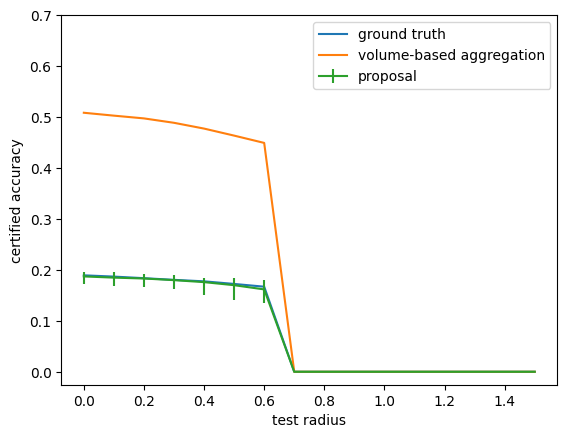

In [199]:
# final_solution = final_solution / len(pp_solutions)
plt.clf()
test_radii = np.arange(0, 1.6, 0.1)
plt.plot(test_radii, server_cert_result, label="ground truth")
plt.plot(test_radii, client_cert_result, label="volume-based aggregation")
# plt.plot(test_radii, final_solution, label="proposal")
plt.errorbar(x=test_radii,
             y=final_solution.squeeze(), yerr=bound, label="proposal")
plt.xlabel("test radius")
plt.ylabel("certified accuracy")

# for solution in pp_solutions:
#     plt.plot(test_radii, solution)

plt.ylim(top=0.7)

plt.legend()